# Prompt selection and testing

This notebook chooses the most appropriate prompt and prompt structure for the OCR correction. 

In [1]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai, get_response_anthropic,  create_config_dict_func, use_df_to_call_llm_api, compare_request_configurations
from evaluate import load
from evaluation_funcs import evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction
import seaborn as sns
import matplotlib.pyplot as plt

dev_transcripts = 'data/dev_data_transcript'

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv('data/dev_data_raw.csv')
test_data_df = pd.read_csv('data/test_data_raw.csv')

/home/jonno/redigitalize/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explore different system prompts

This explores a range of system prompt to find the one that appears to work the best, we use gpt4 as the baseline model.

Although there is no comparison with all models we do test gpt3.5 gpt4, clause haiku and claude opus, in addition we put the prompt in the system message and the prompt after the text becuase this may affect the quality of the result. When the prompt is after the text the response has "nosm_" (no system message) appended to the file name

In [2]:
#Create a modular set of system messages that can be combined in different ways
basic_prompt = "Please recover the text from the corrupted OCR."
expertise_prompt = "You are an expert in post-OCR correction of documents."
recover_prompt = "Using the context available from the text please recover the most likely original text from the corrupted OCR."
publication_context_prompt = "The text is from an english newspaper in the 1800's."
text_context_prompt = "The text may be an advert or article and may be missing the beggining or end."
additional_instructions_prompt = "Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."

#combine all the message parts into a variety of system messages, a tuple is used where 0 is the name of the message and 1 is the message itself
#N.B. This is not and exhaustive combination as that would be very expensive and likley not yield significantly better results
system_messages_list = [
('basic_prompt', basic_prompt),
('expert_basic_prompt', expertise_prompt + ' '+ basic_prompt),
('expert_recover_prompt', expertise_prompt + ' '+ recover_prompt),
('expert_recover_publication_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt),
('expert_recover_text_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + text_context_prompt),
('expert_recover_publication_text_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt + ' ' + text_context_prompt),
('expert_recover_instructions_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + additional_instructions_prompt),
('full_context_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt + ' ' + text_context_prompt+ ' ' + additional_instructions_prompt)
]

The below function is used to make the creation of the config dictionaries for the test more compact and increase readability

In [63]:
def create_message_test_configs(system_messages_list, get_response_func, engine):
    message_test_configs = []
    for iter_system_message in system_messages_list:
        message_test_configs.append(
            create_config_dict_func(
                get_response_func=get_response_func,
                rate_limiter=RateLimiter(50000),
                engine=engine,
                system_message_template=iter_system_message[1],
                prompt_template="{content_html}",
                additional_args={'response_name': iter_system_message[0]}
            )
        )
        message_test_configs.append(
            create_config_dict_func(
                get_response_func=get_response_func,
                rate_limiter=RateLimiter(50000),
                engine=engine,
                system_message_template="",
                prompt_template="{content_html}" + f"""\n\n""" + iter_system_message[1],
                additional_args={'response_name': "nosm_"+iter_system_message[0]}
            )
        )
    return message_test_configs

## Create configs and run tests

In [85]:
#gpt configs
gpt3_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_openai, "gpt-3.5-turbo")
gpt4_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_openai, 'gpt-4-turbo-preview')

#claude configs
haiku_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_anthropic, "claude-3-haiku-20240307")
opus_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_anthropic, "claude-3-opus-20240229")

#run the experiment on all the prompt configs and save to the folder
compare_request_configurations(dev_data_df, 
                               gpt3_prompt_testing_configs + gpt4_prompt_testing_configs + haiku_prompt_testing_configs + opus_prompt_testing_configs,
                               folder_path='./data/dev_system_message_variants')

## Evaluate system prompt tests

We evaluate the system prompts below to see if thre is any significant difference between the prompts


In [86]:
wer = load("wer")
cer = load("cer")

In [73]:
raw_dev_ocr_scores = evaluate_correction_performance('data/dev_raw_ocr', dev_transcripts, wer, cer, 'raw_ocr')

In [113]:
corrected_folder = './data/dev_system_message_variants'

performance_eval = evaluate_correction_performance_folders(corrected_folder, dev_transcripts, wer, cer)

performance_eval =  performance_eval.loc[(performance_eval['File Name']!='slug_ar02501_periodical_pc_issue_tec_06121884_page_number_25.txt'),:]

performance_eval['type'] = performance_eval['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")

performance_eval['model'] = performance_eval['type'].str.split('_').str[-1]

In [114]:
test = get_metric_error_reduction(performance_eval, raw_dev_ocr_scores)

In [143]:
test.loc[test['type'].str.contains('opus')].groupby('type').describe().filter(regex = '50|mean').round(2).sort_values(('CER', '50%'))

WER           CER  \
                                                     mean    50%   mean   
type                                                                      
nosm_expert_recover_publication_text_prompt_cla...  56.55  74.70 -29.86   
nosm_expert_recover_publication_prompt_claude-3...  71.64  75.47  44.57   
expert_recover_publication_prompt_claude-3-opus...  71.07  77.36  41.74   
full_context_prompt_claude-3-opus-20240229          68.79  77.39  25.49   
expert_recover_text_prompt_claude-3-opus-20240229   72.19  77.36  44.01   
basic_prompt_claude-3-opus-20240229                 72.25  77.36  41.81   
nosm_expert_recover_prompt_claude-3-opus-20240229   72.85  76.02  49.35   
nosm_expert_recover_text_prompt_claude-3-opus-2...  71.35  75.86  50.45   
nosm_basic_prompt_claude-3-opus-20240229            70.73  76.02  47.31   
expert_recover_publication_text_prompt_claude-3...  70.79  77.36  42.16   
expert_recover_prompt_claude-3-opus-20240229        63.66  78.30   4.86   
expert_basic_prompt_claude-3-opus-20240229          75.92  79.25  59.19   
nosm_expert_basic_prompt_claude-3-opus-20240229     73.73  77.59  56.30   
expert_recover_instructions_prompt_claude-3-opu...  73.67  80.46  46.82   
nosm_full_context_prompt_claude-3-opus-20240229     73.42  80.46  58.95   
nosm_expert_recover_instructions_prompt_claude-...  73.95  80.46  55.57   

                                                          lev_dist         
                                                      50%     mean    50%  
type                                                                       
nosm_expert_recover_publication_text_prompt_cla...  43.62   -29.53  45.00  
nosm_expert_recover_publication_prompt_claude-3...  49.56    43.02  48.07  
expert_recover_publication_prompt_claude-3-opus...  55.14    39.58  52.66  
full_context_prompt_claude-3-opus-20240229          55.41    25.91  56.00  
expert_recover_text_prompt_claude-3-opus-20240229   56.22    42.49  53.72  
basic_prompt_claude-3-opus-20240229                 58.38    40.48  55.60  
nosm_expert_recover_prompt_claude-3-opus-20240229   58.54    47.96  53.88  
nosm_expert_recover_text_prompt_claude-3-opus-2...  58.71    49.13  58.31  
nosm_basic_prompt_claude-3-opus-20240229            59.73    45.54  49.76  
expert_recover_publication_text_prompt_claude-3...  60.00    40.97  55.60  
expert_recover_prompt_claude-3-opus-20240229        63.23     5.51  55.60  
expert_basic_prompt_claude-3-opus-20240229          64.39    56.97  61.79  
nosm_expert_basic_prompt_claude-3-opus-20240229     64.86    54.26  58.99  
expert_recover_instructions_prompt_claude-3-opu...  68.01    45.19  62.87  
nosm_full_context_prompt_claude-3-opus-20240229     68.78    57.84  66.36  
nosm_expert_recover_instructions_prompt_claude-...  69.66    53.61  61.94

In [148]:
performance_eval2 = performance_eval.copy()
performance_eval2['type'] = performance_eval2['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")
performance_eval2['model'] = performance_eval2['type'].str.split('_').str[-1]
performance_eval2 = performance_eval2.loc[performance_eval2['model'].str.contains('gpt-4')]
performance_eval2.drop(columns = 'File Name').groupby(['type', 'model']).describe().filter(regex = '50|mean').round(2).sort_values(('lev_dist', '50%'))

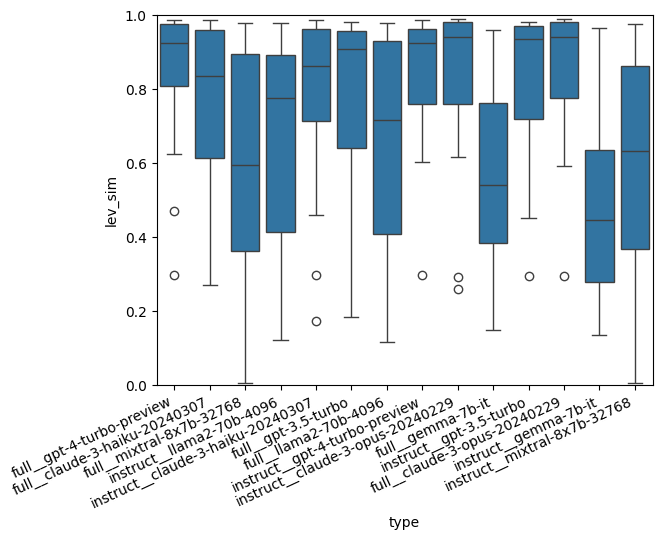

In [160]:
sns.boxplot(data = performance_eval, x = 'type', y = 'lev_sim')
plt.xticks(rotation=25, ha = 'right')  # Rotate labels to 45 degrees
plt.ylim([0, 1.0])
plt.show()

## Conclusions of the prompt test

It appears that the placing the prompt after the text instead of using the system prompt gives the best results. However, the prompts did give significantlty different performance.  I think that perhaps using the `full_context_prompt` and the `expert_recover_publication_prompt` with no system message and the prompt after the text may be the best option. This will require twice as much compute as I was planning to use.

# Create basic and no message responses

Having identified two different prompts and that the prompts appear to work better when places after the text we can now compare the different models


The below code creates the basic configuration dictionaries for each model and then fills in the with the two different prompt messages creating a single list of all basic prompt/model configurations. It then calls all the LLM's and saves the results.
This works in series so takes a while.

In [169]:
#Create the prompt/system message using the best performing from the previous section

full_prompt = "{content_html}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. The text is from an english newspaper in the 1800's. The text may be an advert or article and may be missing the beggining or end. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

instruct_prompt = "{content_html}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""

boros_basic  = "{content_html}"+f""" \n \n """ +"Correct the text"

boros_complex  ="{content_html}"+f""" \n \n """ + f"""Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents.
Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. 
Do not write anything else than the corrected text."""

In [173]:
groq_alt_endpoint = {'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}}

basic_model_configs = pd.DataFrame({
    'get_response_func': [get_response_openai, get_response_openai, get_response_anthropic, get_response_anthropic, 
                          get_response_openai, get_response_openai, get_response_openai], 
    'engine': ['gpt-3.5-turbo', 'gpt-4-turbo-preview', "claude-3-haiku-20240307", "claude-3-opus-20240229", 
               'mixtral-8x7b-32768', 'llama2-70b-4096', 'gemma-7b-it'],
    'additional_args': [
        {}, {}, {}, {}, 
        groq_alt_endpoint, 
        groq_alt_endpoint, 
        groq_alt_endpoint
    ]
})

base_model_configs= []

for index, row in basic_model_configs.iterrows():
    #modify the response name for the type
    row['additional_args']['response_name'] = 'full_'
    base_model_configs.append(

        create_config_dict_func(
    get_response_func = row['get_response_func'],
    rate_limiter = RateLimiter(40000),
    engine = row['engine'],
    system_message_template = "",
    prompt_template =  full_prompt,
    additional_args=row['additional_args']
    )

    )

nosm_model_configs = []

for index, row in basic_model_configs.iterrows():
    #modify the response name for the type
    row['additional_args']['response_name'] = 'instruct_' 
    nosm_model_configs.append(

        create_config_dict_func(
    get_response_func = row['get_response_func'],
    rate_limiter = RateLimiter(40000),
    engine = row['engine'],
    system_message_template = "",
    prompt_template =  instruct_prompt ,
    additional_args=row['additional_args']
    )

    )

boros_list = [create_config_dict_func(
    get_response_func = get_response_openai,
    rate_limiter = RateLimiter(40000),
    engine = 'gpt-4-turbo-preview',
    system_message_template = "",
    prompt_template =  boros_complex ,
    additional_args={"response_name":"boros_complex_"}
),

create_config_dict_func(
    get_response_func = get_response_openai,
    rate_limiter = RateLimiter(40000),
    engine = 'gpt-4-turbo-preview',
    system_message_template = "",
    prompt_template =  boros_basic ,
    additional_args={"response_name":"boros_basic_"}
),

create_config_dict_func(
    get_response_func = get_response_anthropic,
    rate_limiter = RateLimiter(40000),
    engine = "claude-3-opus-20240229",
    system_message_template = "",
    prompt_template =  boros_basic ,
    additional_args={"response_name":"boros_complex_"}
)]




model_configs = base_model_configs + nosm_model_configs + boros_list

compare_request_configurations(dev_data_df, model_configs, folder_path='./data/dev_corrected_base')
    

In [174]:
corrected_folder = './data/dev_corrected_base'

performance_eval =  evaluate_correction_performance_folders(corrected_folder, dev_transcripts, wer, cer)


performance_eval =  performance_eval.loc[(performance_eval['File Name']!='slug_ar02501_periodical_pc_issue_tec_06121884_page_number_25.txt') &
                     (performance_eval['type']!='gpt3_boros_blank_gpt-3.5-turbo'),:]

# Evaluate the prompts across all models

In [175]:
test = get_metric_error_reduction(performance_eval, raw_dev_ocr_scores)

test.groupby('type').describe().filter(regex = '50|mean').round(2).sort_values(('lev_dist', '50%'))

WER            CER        lev_dist  \
                                        mean    50%    mean    50%     mean   
type                                                                          
full__gemma-7b-it                      -5.62  -2.51 -178.23 -20.73  -169.37   
instruct__gemma-7b-it                  -5.04   1.08 -249.75 -20.41  -237.58   
instruct__mixtral-8x7b-32768           30.89  47.79 -116.89  -6.08  -110.08   
full__mixtral-8x7b-32768               26.93  41.79 -146.28  -4.27  -138.44   
full__llama2-70b-4096                  -3.91  55.40 -290.94  -4.12  -289.14   
instruct__llama2-70b-4096              37.29  45.61  -52.95   3.00   -65.63   
full__claude-3-haiku-20240307          52.62  61.15  -24.53  28.05   -20.74   
boros_complex__claude-3-opus-20240229  59.86  70.85  -55.37  36.00   -49.38   
full__gpt-3.5-turbo                    54.55  70.75   26.31  39.70    23.73   
instruct__claude-3-haiku-20240307      58.14  69.89    8.32  47.51     9.39   
instruct__gpt-3.5-turbo                69.54  74.27   51.08  56.52    47.85   
boros_basic__gpt-4-turbo-preview       70.61  75.86   54.88  54.18    52.39   
instruct__gpt-4-turbo-preview          70.96  75.44   40.36  58.23    38.91   
full__gpt-4-turbo-preview              72.09  79.31   52.75  61.63    50.50   
boros_complex__gpt-4-turbo-preview     71.98  77.19   43.96  61.35    41.64   
instruct__claude-3-opus-20240229       57.05  77.70   23.18  61.30    22.99   
full__claude-3-opus-20240229           75.32  80.46   60.10  69.33    57.60   

                                              
                                         50%  
type                                          
full__gemma-7b-it                     -19.76  
instruct__gemma-7b-it                 -15.52  
instruct__mixtral-8x7b-32768           -6.95  
full__mixtral-8x7b-32768               -4.19  
full__llama2-70b-4096                  -2.54  
instruct__llama2-70b-4096               2.54  
full__claude-3-haiku-20240307          25.43  
boros_complex__claude-3-opus-20240229  33.77  
full__gpt-3.5-turbo                    38.77  
instruct__claude-3-haiku-20240307      47.09  
instruct__gpt-3.5-turbo                50.91  
boros_basic__gpt-4-turbo-preview       54.28  
instruct__gpt-4-turbo-preview          57.45  
full__gpt-4-turbo-preview              58.64  
boros_complex__gpt-4-turbo-preview     60.45  
instruct__claude-3-opus-20240229       61.23  
full__claude-3-opus-20240229           63.69

In [176]:
performance_eval2 = performance_eval.copy()
performance_eval2['type'] = performance_eval2['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")
performance_eval2['model'] = performance_eval2['type'].str.split('_').str[-1]

#The below line allows you to look at an individual model
#performance_eval2 = performance_eval2.loc[performance_eval2['model'].str.contains('gpt-4')]

performance_eval2.drop(columns = 'File Name').groupby(['type', 'model']).describe().filter(regex = '50|mean').round(2).sort_values(('WER', '50%'))

WER        \
                                                              mean   50%   
type                                  model                                
full__claude-3-opus-20240229          claude-3-opus-20240229  0.23  0.11   
instruct__claude-3-opus-20240229      claude-3-opus-20240229  0.33  0.12   
full__gpt-4-turbo-preview             gpt-4-turbo-preview     0.26  0.16   
instruct__gpt-3.5-turbo               gpt-3.5-turbo           0.29  0.16   
boros_complex__gpt-4-turbo-preview    gpt-4-turbo-preview     0.24  0.17   
boros_basic__gpt-4-turbo-preview      gpt-4-turbo-preview     0.26  0.18   
instruct__gpt-4-turbo-preview         gpt-4-turbo-preview     0.25  0.19   
instruct__haiku                       haiku                   0.32  0.26   
boros_complex__claude-3-opus-20240229 claude-3-opus-20240229  0.32  0.30   
full__gpt-3.5-turbo                   gpt-3.5-turbo           0.36  0.32   
full__haiku                           haiku                   0.35  0.32   
full__llama2-70b-4096                 llama2-70b-4096         0.78  0.41   
instruct__mixtral-8x7b-32768          mixtral-8x7b-32768      0.52  0.45   
instruct__llama2-70b-4096             llama2-70b-4096         0.53  0.51   
full__mixtral-8x7b-32768              mixtral-8x7b-32768      0.54  0.56   
instruct__gemma-7b-it                 gemma-7b-it             0.80  0.86   
full__gemma-7b-it                     gemma-7b-it             0.83  0.91   

                                                               CER        \
                                                              mean   50%   
type                                  model                                
full__claude-3-opus-20240229          claude-3-opus-20240229  0.13  0.05   
instruct__claude-3-opus-20240229      claude-3-opus-20240229  0.22  0.06   
full__gpt-4-turbo-preview             gpt-4-turbo-preview     0.15  0.06   
instruct__gpt-3.5-turbo               gpt-3.5-turbo           0.17  0.06   
boros_complex__gpt-4-turbo-preview    gpt-4-turbo-preview     0.14  0.07   
boros_basic__gpt-4-turbo-preview      gpt-4-turbo-preview     0.15  0.06   
instruct__gpt-4-turbo-preview         gpt-4-turbo-preview     0.15  0.06   
instruct__haiku                       haiku                   0.21  0.13   
boros_complex__claude-3-opus-20240229 claude-3-opus-20240229  0.23  0.20   
full__gpt-3.5-turbo                   gpt-3.5-turbo           0.22  0.08   
full__haiku                           haiku                   0.24  0.16   
full__llama2-70b-4096                 llama2-70b-4096         0.55  0.29   
instruct__mixtral-8x7b-32768          mixtral-8x7b-32768      0.39  0.37   
instruct__llama2-70b-4096             llama2-70b-4096         0.33  0.22   
full__mixtral-8x7b-32768              mixtral-8x7b-32768      0.41  0.44   
instruct__gemma-7b-it                 gemma-7b-it             0.52  0.57   
full__gemma-7b-it                     gemma-7b-it             0.46  0.49   

                                                             lev_dist         \
                                                                 mean    50%   
type                                  model                                    
full__claude-3-opus-20240229          claude-3-opus-20240229   150.52   87.0   
instruct__claude-3-opus-20240229      claude-3-opus-20240229   380.76  111.0   
full__gpt-4-turbo-preview             gpt-4-turbo-preview      164.62   91.0   
instruct__gpt-3.5-turbo               gpt-3.5-turbo            189.38  119.0   
boros_complex__gpt-4-turbo-preview    gpt-4-turbo-preview      183.90   98.0   
boros_basic__gpt-4-turbo-preview      gpt-4-turbo-preview      170.90   91.0   
instruct__gpt-4-turbo-preview         gpt-4-turbo-preview      186.76   91.0   
instruct__haiku                       haiku                    323.05  118.0   
boros_complex__claude-3-opus-20240229 claude-3-opus-20240229   233.48  154.0   
full__gpt-3.5-turbo                   gpt-3.5-turbo          

# Test toot at the end

This is some messy junk feel free to ignore

In [3]:
OCR_text = f"""fcm E ¥ gNlGP «® WOTH ) THE R&PP ^ Ol SPBRBTTS . [ The following Letter was written at our request . The writer , a German friend , whose integrity and clear-headedness would command attention to whatever he might assert , informed us of his proposed visit to a house where the Rappitcs were to exhibit , and we begged him to furnish us with a report . We print his letter without any alteration : its statements will , we think , set the reader speculating .Let it be distinctly borne in mind , however , that in printing this Letter we give no countenance whatever to the pretended explanation of " Rapping . " We have our own views of the jugglery by which the "ghosts " are made to communicate with persons willing to pay for the interview , and in a very short time we hope to lay before our readers something like an experimental result . ] My dear Sir , —When I proposed to give you a report on these new prophets , who , if as true as they arc new , open to us a wide and most interesting field for inquiry , overthrow ancient and modem systems of science and belief , shake to the very foundation revealed religion andChristianity , hut , on the other hand , arc telling almost equally strong against Pantheism mid Atheism , I had not seen those prophets , expounders , mediums , or whatever you may call them , myself ; hut what I heard from a friend , a clear-sighted , well-informed , by no moans " gullible , " or over-credulous gentleman , who had paid them ii visit , had made me anxious to see and judge for myself ; and he having determined , for better satisfaction , to have the Medium ( and the spirits ) at his own house , and having kindly invited me to be present on the occasion , 1 offered to furnish you with a statement of the result of the evening , which I now , agreeably to your wish , lay before you .We were five of us in the library , —my friend , his wife , his sister , his nephew , and myself , —when the footman , handing in a card , announced "Mrs . JIayden . " Her entrance and deportment were easy , unembarrassed , and yet not " business-like ; " her exterior rather prepossessing ; an intelligent countenance , with , perhaps , a slight touch of Yankccisin in the corner of the eye ; and the conversation soon bring established , showed that she did not lack those powers of speech so peculiar to the . citizens of the great Republic ; though certain mistakes now and then recurring in the conjugation of verbs , indicated that nhe could not have had a very fin ;! -rate education . We took our seats round the table on which the card had been placed , [ mid , — "Mr . and Mrs . W . R . Jlirydeii , L' 2 , Queen Anne-street , Cavenuish-. squarc . " Expectation created silence , now and then broken by . qiiestions in a low voice , addressed to the Medium , and by the wheels of carriages that brought guests to an evening party at a neighbouring house , and thus tnadd the otherwise very quirt sired ; liither noisy . Tho raps which the Medium and one or two of us , after we had been seated for about ten"""

In [4]:
system_message = f"""Please recover the text from the corrupted OCR, providing appropriate paragraph breaks. 
Do not add any text, commentary, or lead in sentences  beyond the recovered text. Do not add a title, or any introductions"""



prompt = OCR_text + "\n\n" + f"""Please recover the text from the corrupted OCR, providing appropriate paragraph breaks. Do not add any text, commentary, or lead in sentences  beyond the recovered text"""

#system_message = ""

#prompt = OCR_text

In [6]:
configurations = [create_config_dict_func(
    get_response_func = get_response_anthropic,
    rate_limiter = RateLimiter(40000),
    engine = "claude-3-haiku-20240307",
    system_message_template = "",
    prompt_template =  "{content_html}"+f""" \n \n """+ system_message,
    additional_args={'response_name':'haiku_nosm_base'}
),

create_config_dict_func(
    get_response_func = get_response_anthropic,
    rate_limiter = RateLimiter(40000),
    engine = "claude-3-opus-20240229",
    system_message_template = system_message,
    prompt_template =  "{content_html}",
    additional_args={'response_name':'opus_base'}
)]





In [8]:
use_df_to_call_llm_api(config_dict, dev_data_raw_df, 'haiku_base' , folder_path='./data/dev_corrected')

/home/jonno/redigitalize/llm_caller.py:237: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  times_df = pd.concat([times_df, pd.DataFrame([new_records], index = [0])], ignore_index=True)


In [ ]:
rate_limiter = RateLimiter(50000)

test = get_response_anthropic(prompt, system_message, rate_limiter, engine="claude-3-haiku-20240307", max_tokens = 4000)

In [ ]:
message

Message(id='msg_01RDuf2hzxmMSCQHRQkQT9XH', content=[ContentBlock(text='Here is the text recovered from the corrupted OCR, with appropriate paragraph breaks:\n\nMy dear Sir, —When I proposed to give you a report on these new prophets, who, if as true as they are new, open to us a wide and most interesting field for inquiry, overthrow ancient and modern systems of science and belief, shake to the very foundation revealed religion and Christianity, but, on the other hand, are telling almost equally strong against Pantheism and Atheism, I had not seen those prophets, expounders, mediums, or whatever you may call them, myself; but what I heard from a friend, a clear-sighted, well-informed, by no means "gullible," or over-credulous gentleman, who had paid them a visit, had made me anxious to see and judge for myself; and he having determined, for better satisfaction, to have the Medium (and the spirits) at his own house, and having kindly invited me to be present on the occasion, I offered t

fcm E ¥ gNlGP «® WOTH ) THE R&PP ^ Ol SPBRBTTS . [ The following Letter was written at our request . The writer , a German friend , whose integrity and clear-headedness would command attention to whatever he might assert , informed us of his proposed visit to a house where the Rappitcs were to exhibit , and we begged him to furnish us with a report . We print his letter without any alteration : its statements will , we think , set the reader speculating .Let it be distinctly borne in mind , however , that in printing this Letter we give no countenance whatever to the pretended explanation of " Rapping . " We have our own views of the jugglery by which the "ghosts " are made to communicate with persons willing to pay for the interview , and in a very short time we hope to lay before our readers something like an experimental result . ] My dear Sir , —When I proposed to give you a report on these new prophets , who , if as true as they arc new , open to us a wide and most interesting field for inquiry , overthrow ancient and modem systems of science and belief , shake to the very foundation revealed religion andChristianity , hut , on the other hand , arc telling almost equally strong against Pantheism mid Atheism , I had not seen those prophets , expounders , mediums , or whatever you may call them , myself ; hut what I heard from a friend , a clear-sighted , well-informed , by no moans " gullible , " or over-credulous gentleman , who had paid them ii visit , had made me anxious to see and judge for myself ; and he having determined , for better satisfaction , to have the Medium ( and the spirits ) at his own house , and having kindly invited me to be present on the occasion , 1 offered to furnish you with a statement of the result of the evening , which I now , agreeably to your wish , lay before you .We were five of us in the library , —my friend , his wife , his sister , his nephew , and myself , —when the footman , handing in a card , announced "Mrs . JIayden . " Her entrance and deportment were easy , unembarrassed , and yet not " business-like ; " her exterior rather prepossessing ; an intelligent countenance , with , perhaps , a slight touch of Yankccisin in the corner of the eye ; and the conversation soon bring established , showed that she did not lack those powers of speech so peculiar to the . citizens of the great Republic ; though certain mistakes now and then recurring in the conjugation of verbs , indicated that nhe could not have had a very fin ;! -rate education . We took our seats round the table on which the card had been placed , [ mid , — "Mr . and Mrs . W . R . Jlirydeii , L' 2 , Queen Anne-street , Cavenuish-. squarc . " Expectation created silence , now and then broken by . qiiestions in a low voice , addressed to the Medium , and by the wheels of carriages that brought guests to an evening party at a neighbouring house , and thus tnadd the otherwise very quirt sired ; liither noisy . Tho raps which the Medium and one or two of us , after we had been seated for about ten

Please recover the text from the corrupted OCR, providing appropriate paragraph breaks. Do not add any text, commentary, or lead in sentences  beyond the recovered text, for example for the text

"Md BRO5n0n D1e] t@ ay"

The correct response would be

"Mr Bronson Died today"

An incorrect response would be 

"Sure here is the recovered text: Mr Bronson died today"

Another incorrect response would be

"Here is the recovered text from the corrupted OCR: Mr Bronson died today"

In both cases a lead in sentence was generated which is why the example responses were incorrect

